In [1]:
import time
import os
from datetime import date
print(time.ctime())
path = os.path.abspath('')
print(path)
today = date.today().strftime('%d.%m.%Y')

import warnings
warnings.filterwarnings('ignore')

Fri Jun 30 14:41:00 2023
/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/experiments


In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_lagos')

In [14]:
config = backend.configuration()
dt = config.dt
print(f"Sampling time: {dt * 1e9} ns")
acquire_alignment = config.timing_constraints['acquire_alignment']
granularity = config.timing_constraints['granularity']
pulse_alignment = config.timing_constraints['pulse_alignment']

import numpy as np

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")
print(f"Lagos granularity: {granularity} ")
defaults = backend.defaults()

Sampling time: 0.2222222222222222 ns
Least common multiple of acquire_alignment and pulse_alignment: 16
Lagos granularity: 16 


In [15]:
GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9

qubit = 0

def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [16]:
from qiskit import pulse
from qiskit.circuit import Parameter, QuantumCircuit, Gate

In [17]:
data_path = '../output/x01_90/00006_x01_90_lagos.h5'

In [18]:
import h5py

result = []
with h5py.File(data_path, 'r') as hf:
    data = hf.get('uks')
    result = data[...]

print(result.shape)

(6, 1, 1, 36)


In [35]:
data = result[5][0][0]

In [38]:
ii = np.array(range(len(data)))

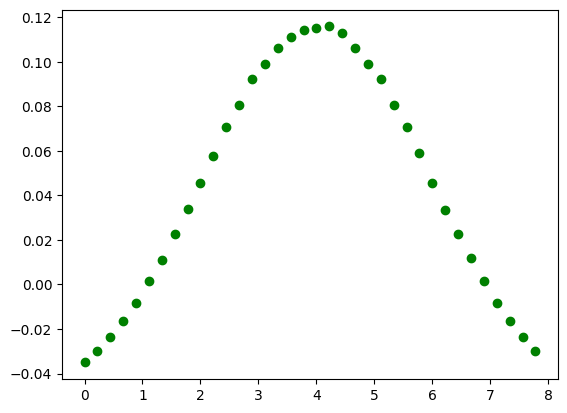

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

T = 8
N = len(data)
dtx = T / N
ops_max_amp = [2 * np.pi * 0.073036776]
Hnames = 'x'
plt.scatter(np.array(dtx * ii), np.array(ops_max_amp * data), color='green', marker='o', label='u' + Hnames + '0')
    

In [40]:
drive_sigma_sec = config.dt * ns
drive_duration_sec = drive_sigma_sec * 1


with pulse.build(backend) as pi01_pulse:
    drive_duration = 1
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    for i in range(len(data)):
        pulse.play(pulse.library.square(duration=drive_duration,
                                        amp=data[i],
                                        phase=0,
                                        name='pi_pulse_' + str(i)), channel=drive_chan)

In [42]:
freq_Hz = defaults.qubit_freq_est[qubit]
freq_GHz = freq_Hz / GHz

with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq_GHz/2, drive_chan)
    pulse.call(pi01_pulse)

In [44]:
qc_01 = QuantumCircuit(1, 1)
qc_01.x(0)
qc_01.add_calibration('x', (0,), exc_schedule, [])

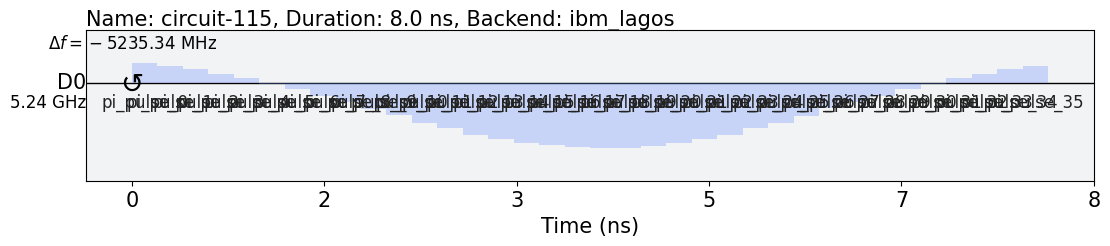

In [45]:
from qiskit import schedule

exec_schedule = schedule(qc_01, backend)
exec_schedule.draw(backend=backend)

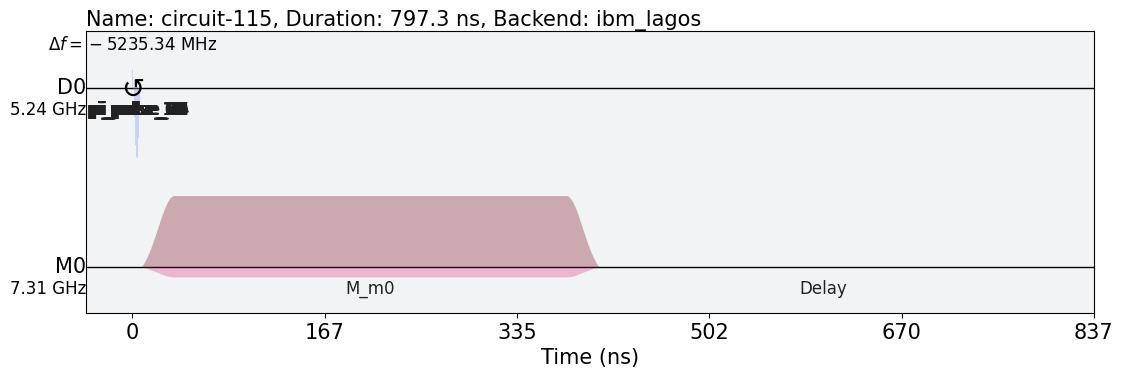

In [46]:
qc_01.measure(0,0)

exec_schedule = schedule(qc_01, backend)
exec_schedule.draw(backend=backend)

In [47]:
num_shots = 1024

job = backend.run(qc_01,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots)

In [52]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

IBMQJobApiError: '\'403 Client Error: Forbidden for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/cif8kqru5mrpmcc0k6og/status/v/1. <!DOCTYPE html>\\n<html lang="en-US">\\n   <head>\\n      <title>Access denied</title>\\n      <meta http-equiv="X-UA-Compatible" content="IE=Edge" />\\n      <meta name="robots" content="noindex, nofollow" />\\n      <meta name="viewport" content="width=device-width,initial-scale=1" />\\n      <link rel="stylesheet" href="/cdn-cgi/styles/errors.css" media="screen" />\\n      <script>\\n(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1020,helpful:a,version:5}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");\\nb.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();\\n</script>\\n\\n      <script>\\n      (function(){function d(c){var b=document.getElementById("copy-label"),a=document.getElementById("cf-details-wrapper-expandable");c.target.checked?a.classList.add("expanded"):(a.classList.remove("expanded"),b.innerText="Click to copy")}if(document.addEventListener){var e=function(){var c=document.getElementById("copy-label");var b=document.getElementById("error-details").textContent;if(navigator.clipboard)navigator.clipboard.writeText(b);else{var a=document.createElement("textarea");a.value=b;a.style.top="0";a.style.left="0";a.style.position="fixed";document.body.appendChild(a);a.focus();a.select();document.execCommand("copy");document.body.removeChild(a)}c.innerText="Copied text to clipboard"};document.addEventListener("DOMContentLoaded",function(){var c=document.getElementById("error-details-checkbox"),b=document.getElementById("click-to-copy-btn");document.getElementById("copy-label").classList.remove("hidden");c.addEventListener("change",d);b.addEventListener("click",e)})}})();\\n      </script>\\n      <script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>\\n   </head>\\n   <body>\\n   <div class="cf-main-wrapper" role="main">\\n      <div class="cf-header cf-section">\\n         <div class="cf-error-title">\\n            <h1>Access denied</h1>\\n            <span class="cf-code-label">Error code <span>1020</span></span>\\n         </div>\\n         <div class="cf-error-description">\\n            <p>You do not have access to api-qcon.quantum-computing.ibm.com.</p><p>The site owner may have set restrictions that prevent you from accessing the site.</p>\\n         </div>\\n      </div>\\n   </div>\\n\\n   <div class="cf-details-wrapper">\\n      <div class="cf-section" role="region">\\n         <div class="cf-expandable" id="cf-details-wrapper-expandable">\\n            <label for="error-details-checkbox" title="Error details" class="cf-expandable-btn">\\n               <p class="cf-dropdown-title">Error details</p>\\n               <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACAAAAAgBAMAAACBVGfHAAAAElBMVEUAAAAwMDAxMTEyMjIwMDAxMTF+89HTAAAABXRSTlMAf2CAMKS61bwAAABTSURBVCjPzcq7DcAgFENR5zMATfo06TNCViAS+6+CeFi6gglw4eLqaPVtaQpXnkApaQT/k0dw70EAUhCA1AnABGACMAGYAEwAkCOAydv+I5xaZhXWbQrD80TkkQAAAABJRU5ErkJggg=="\\n               class="cf-caret-icon" id="caret-icon" alt="Caret icon" />\\n            </label>\\n\\n            <input id="error-details-checkbox" class="hidden" type="checkbox">\\n\\n            <div class="cf-expandable-error-info hidden">\\n               <p class="cf-error-copy-description">Provide the site owner this information.</p>\\n               <button class="cf-click-to-copy-btn" id="click-to-copy-btn" title="Click to copy" type="button">\\n<div class="cf-error-wrapper" id="error-details"><p class="cf-error-details-endpoint">I got an error when visiting api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/cif8kqru5mrpmcc0k6og/status/v/1.</p>\\n\\n<p>Error code: 1020</p>\\n<p>Ray ID: 7df77b733c9621be</p>\\n<p>Country: VN</p>\\n<p>Data center: hkg01</p>\\n<p>IP: 42.116.202.13</p>\\n<p>Timestamp: 2023-06-30 15:35:59 UTC</p>\\n</div>\\n                  <p class="cf-copy-label hidden" id="copy-label">Click to copy</p>\\n               </button>\\n            </div>\\n         </div>\\n      </div>\\n\\n      <div class="clearfix cf-footer cf-section" role="contentinfo">\\n      <div class="cf-column">\\n           <div class="feedback-hidden py-8 text-center" id="error-feedback">\\n    <div id="error-feedback-survey" class="footer-line-wrapper">\\n        Was this page helpful?\\n        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>\\n        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>\\n    </div>\\n    <div class="feedback-success feedback-hidden" id="error-feedback-success">\\n        Thank you for your feedback!\\n    </div>\\n</div>\\n\\n      </div>\\n         <div class="cf-column cf-footer-line-wrapper text-center">\\n            <p>\\n               Performance &amp; security by <a rel="noopener noreferrer" href="https://www.cloudflare.com?utm_source=1020_error" target="_blank">Cloudflare <img class="external-link" title="Opens in new tab" src="/cdn-cgi/images/external.png" alt="External link"></a>\\n            </p>\\n         </div>\\n      </div>\\n   </div>\\n</body>\\n</html>\\n\''